# Breast Cancer QA Chatbot


This breast cancer QA chatbot provides accurate, accessible educational information within the medical domain. With breast cancer affecting 1 in 8 women globally, there is a critical need for reliable, immediate access to information about symptoms, treatments, and prevention. The chatbot addresses healthcare accessibility gaps by offering 24/7 support, reducing reliance on unreliable online sources, and providing evidence-based responses that alleviate patient anxiety. This specialized approach is necessary because general-purpose chatbots lack the domain-specific medical knowledge required for accurate information delivery.

In [14]:
# Import the necessary packages

import os
import re
import json
import nltk
import torch
import string
import logging
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
from pathlib import Path
from datetime import datetime
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from dataclasses import dataclass
from transformers import (
    set_seed,
    EarlyStoppingCallback,
    Trainer, TrainingArguments,
    AutoTokenizer, AutoModelForCausalLM,
)
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize, sent_tokenize
from typing import List, Dict, Any, Tuple, Optional, Union


import warnings

In [2]:
# Load the data

input_file = "./data/raw/breast_cancer_dataset.csv"
output_file = "./data/processed/"

df = pd.read_csv(input_file)
df

,Questions,Answers,Patterns,Tags,Source
0,What is breast cancer?,Breast cancer is a malignant tumor that develo...,What precisely is breast cancer. Define breast...,breast cancer,https://www.medscape.com/answers/1947145-15523...
1,What are the signs and symptoms of breast cancer?,"Early breast cancers may be asymptomatic, and ...",What are the indications of breast cancer. Wha...,signs symptoms,https://www.medscape.com/answers/1947145-15523...
2,What is included in the evaluation of breast c...,Evaluation of breast cancer includes the follo...,What is included in a breast cancer evaluation...,evaluation,https://www.medscape.com/answers/1947145-15524...
3,Which physical findings suggest breast cancer?,The following physical findings should raise c...,Which physical signs point to breast cancer. W...,indicative indicators,https://www.medscape.com/answers/1947145-15524...
4,What features of a palpable lump suggest breas...,If a palpable lump is found and possesses any ...,what is lump. What characteristics of a palpab...,lump palpable,https://www.medscape.com/answers/1947145-15524...
...,...,...,...,...,...
182,Which medications in the drug class Calcium Me...,Bisphosphonates are complementary to chemother...,Calcium metabolism modifiers medication usage....,Calcium metabolism modifiers,https://www.medscape.com/answers/1947145-15596...
183,Which medications in the drug class Antineopla...,"Anthracyclines work in multiple ways, includin...",Antineoplastics Anthracycline medication usage...,Anthracycline medications,https://www.medscape.com/answers/1947145-15597...
184,Which medications in the drug class Antineopla...,Alkylating agents constitute one of the earlie...,Antioneplastics Alkylating medication usage. W...,Alkylating medications,https://www.medscape.com/answers/1947145-15597...
185,Which medications in the drug class PD-1/PD-L1...,PD-L1 is expressed on the surface of activated...,PD 1 / PD L1 inhibitors usage. PD-1/PD-L1 medi...,PD-1/PD-L1 PD-1 PD-L1,https://www.medscape.com/answers/1947145-18545...


In [5]:
df.describe()

,Questions,Answers,Patterns,Tags,Source
count,187,186,187,187,187
unique,184,180,184,173,187
top,What are the signs and symptoms of breast cancer?,"Overall, patients with mucinous carcinoma have...",guidelines for sentinel lymph node biopsy. gui...,sentinel lymph node biopsy. axillary lymph nod...,https://www.medscape.com/answers/1947145-15523...
freq,2,2,3,4,1


In [6]:
print("Null values per column:\n", df.isnull().sum())

Null values per column:
 Questions    0
Answers      1
Patterns     0
Tags         0
Source       0
dtype: int64


In [7]:
# Fill nulls with empty string
df.fillna("", inplace=True)

# Remove duplicate rows
df.drop_duplicates(inplace=True)

In [9]:
df.head()

,Questions,Answers,Patterns,Tags,Source
0,What is breast cancer?,Breast cancer is a malignant tumor that develo...,What precisely is breast cancer. Define breast...,breast cancer,https://www.medscape.com/answers/1947145-15523...
1,What are the signs and symptoms of breast cancer?,"Early breast cancers may be asymptomatic, and ...",What are the indications of breast cancer. Wha...,signs symptoms,https://www.medscape.com/answers/1947145-15523...
2,What is included in the evaluation of breast c...,Evaluation of breast cancer includes the follo...,What is included in a breast cancer evaluation...,evaluation,https://www.medscape.com/answers/1947145-15524...
3,Which physical findings suggest breast cancer?,The following physical findings should raise c...,Which physical signs point to breast cancer. W...,indicative indicators,https://www.medscape.com/answers/1947145-15524...
4,What features of a palpable lump suggest breas...,If a palpable lump is found and possesses any ...,what is lump. What characteristics of a palpab...,lump palpable,https://www.medscape.com/answers/1947145-15524...


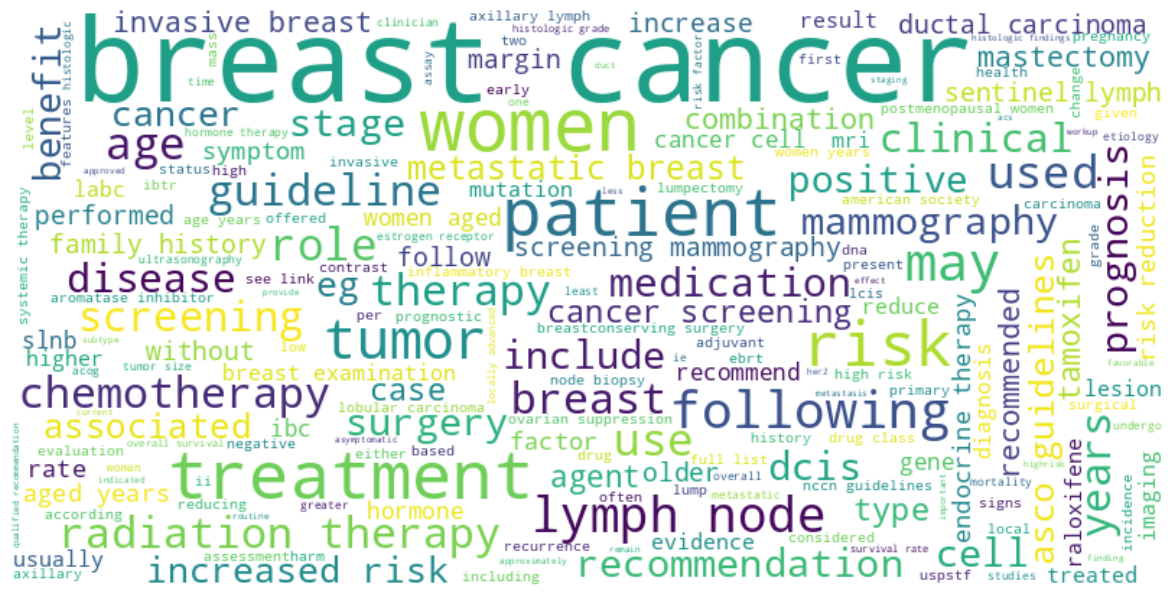

In [10]:
stopwords = set(STOPWORDS)

def clean_text(text):
    text = text.lower()
    text = text.translate(str.maketrans("", "", string.punctuation))
    return text

combined_text = " ".join(clean_text(q + " " + a) for q, a in zip(df['Questions'], df['Answers']))

wordcloud = WordCloud(stopwords=stopwords, width=800, height=400, background_color='white').generate(combined_text)

plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [11]:
@dataclass
class ModelConfig:
    """Configuration for model parameters"""
    base_model_name: str = "microsoft/DialoGPT-small"

    # Tokenization settings
    max_sequence_length: int = 512
    padding_strategy: str = "max_length"
    truncation: bool = True

In [12]:
@dataclass
class TrainingConfig:
    """Configuration for training parameters"""
    # Training hyperparameters
    learning_rate: float = 5e-5
    batch_size: int = 4
    num_epochs: int = 5
    warmup_steps: int = 100

    # Gradient and optimization settings
    gradient_accumulation_steps: int = 1
    max_grad_norm: float = 1.0
    weight_decay: float = 0.01

    # Model saving and evaluation
    save_strategy: str = "epoch"
    eval_strategy: str = "epoch"
    logging_steps: int = 10
    save_total_limit: int = 3

    # Early stopping
    early_stopping_patience: int = 3
    early_stopping_threshold: float = 0.001

In [13]:
@dataclass
class DataConfig:
    """Configuration for data processing"""
    train_data_path: str = "data/raw/breast_cancer_data.csv"
    test_data_path: str = "data/processed/test_data.csv"

    # Data preprocessing
    test_size: float = 0.2
    validation_size: float = 0.1
    random_state: int = 42

    # Text cleaning parameters
    min_question_length: int = 5
    max_question_length: int = 500
    min_answer_length: int = 10
    max_answer_length: int = 1000

    # Data augmentation
    use_patterns: bool = True
    expand_with_paraphrases: bool = False

In [15]:
@dataclass
class InferenceConfig:
    """Configuration for inference parameters"""
    # Generation settings
    max_new_tokens: int = 150
    temperature: float = 0.7
    top_p: float = 0.9
    top_k: int = 50
    do_sample: bool = True
    repetition_penalty: float = 1.1

    # Response filtering
    min_response_length: int = 10
    max_response_length: int = 300

    # Domain filtering
    domain_keywords: List[str] = None

    def __post_init__(self):
        if self.domain_keywords is None:
            self.domain_keywords = [
                'breast cancer', 'breast tumor', 'breast carcinoma', 'mammogram',
                'mastectomy', 'lumpectomy', 'chemotherapy', 'radiation therapy',
                'hormone therapy', 'her2', 'estrogen receptor', 'progesterone receptor',
                'metastasis', 'lymph nodes', 'oncology', 'biopsy', 'breast screening',
                'brca', 'genetic testing', 'breast self-exam', 'ductal carcinoma',
                'lobular carcinoma', 'inflammatory breast cancer', 'triple negative',
                'tumor', 'cancer', 'malignant', 'benign', 'diagnosis', 'treatment',
                'symptoms', 'prevention', 'risk factors', 'screening', 'therapy'
            ]

In [16]:
@dataclass
class UIConfig:
    """Configuration for user interface"""
    gradio_server_name: str = "0.0.0.0"
    gradio_server_port: int = 7860
    gradio_share: bool = True

    # Interface customization
    title: str = "🎗️ Breast Cancer Information Chatbot"
    description: str = "Ask me any questions about breast cancer symptoms, treatment, diagnosis, or prevention."

    # Example questions
    example_questions: List[str] = None

    def __post_init__(self):
        if self.example_questions is None:
            self.example_questions = [
                "What is breast cancer?",
                "What are the symptoms of breast cancer?",
                "How is breast cancer diagnosed?",
                "What are the treatment options for breast cancer?",
                "How can I prevent breast cancer?",
                "What is a mammogram?",
                "What is chemotherapy?",
                "What are the risk factors for breast cancer?",
                "What is the difference between ductal and lobular carcinoma?",
                "What does triple negative breast cancer mean?"
            ]

In [17]:
@dataclass
class PathConfig:
    """Configuration for file paths"""
    # Model directories
    base_model_dir: str = "models/base"
    fine_tuned_model_dir: str = "models/fine_tuned"
    experiment_dir: str = "experiments"

    # Data directories
    data_dir: str = "data"
    logs_dir: str = "logs"
    output_dir: str = "output"

    # Specific file paths
    training_log_file: str = "logs/training.log"
    evaluation_results_file: str = "output/evaluation_results.json"
    hyperparameter_results_file: str = "output/hyperparameter_results.csv"

    def __post_init__(self):
        # Create directories if they don't exist
        os.makedirs(self.base_model_dir, exist_ok=True)
        os.makedirs(self.fine_tuned_model_dir, exist_ok=True)
        os.makedirs(self.experiment_dir, exist_ok=True)
        os.makedirs(self.data_dir, exist_ok=True)
        os.makedirs(self.logs_dir, exist_ok=True)
        os.makedirs(self.output_dir, exist_ok=True)

In [18]:
@dataclass
class ExperimentConfig:
    """Configuration for hyperparameter experiments"""
    # Hyperparameter ranges to test
    learning_rates: List[float] = None
    batch_sizes: List[int] = None
    num_epochs_options: List[int] = None

    # Experiment settings
    num_trials: int = 10
    optimization_metric: str = "bleu_score"  # I also experimented with these ["eval_loss", "response_relevance"]

    def __post_init__(self):
        if self.learning_rates is None:
            self.learning_rates = [1e-5, 2e-5, 3e-5, 5e-5, 1e-4]

        if self.batch_sizes is None:
            self.batch_sizes = [2, 4, 8]

        if self.num_epochs_options is None:
            self.num_epochs_options = [2, 3, 4]

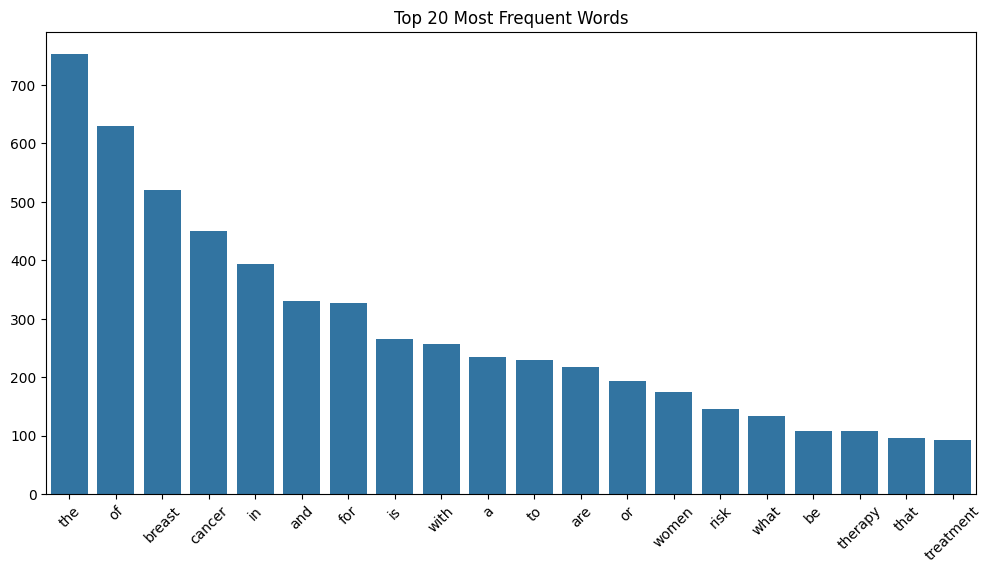

In [19]:
words = combined_text.split()
word_freq = Counter(words)

# Most common 20 words
common_words = word_freq.most_common(20)
words, counts = zip(*common_words)

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x=list(words), y=list(counts))
plt.xticks(rotation=45)
plt.title("Top 20 Most Frequent Words")
plt.show()

In [20]:
class Config:
    """Main configuration class that combines all configurations"""

    def __init__(self):
        self.model = ModelConfig()
        self.training = TrainingConfig()
        self.data = DataConfig()
        self.inference = InferenceConfig()
        self.ui = UIConfig()
        self.paths = PathConfig()
        self.experiment = ExperimentConfig()

        # Environment variables
        self.device = "cuda" if os.getenv("CUDA_AVAILABLE", "false").lower() == "true" else "cpu"
        self.seed = int(os.getenv("RANDOM_SEED", "42"))
        self.debug = os.getenv("DEBUG", "false").lower() == "true"

        # Logging configuration
        self.log_level = os.getenv("LOG_LEVEL", "INFO")
        self.wandb_project = os.getenv("WANDB_PROJECT", "breast-cancer-chatbot")
        self.use_wandb = os.getenv("USE_WANDB", "false").lower() == "true"

    def to_dict(self) -> Dict[str, Any]:
        """Convert configuration to dictionary for logging"""
        return {
            "model": self.model.__dict__,
            "training": self.training.__dict__,
            "data": self.data.__dict__,
            "inference": self.inference.__dict__,
            "ui": self.ui.__dict__,
            "paths": self.paths.__dict__,
            "experiment": self.experiment.__dict__,
            "device": self.device,
            "seed": self.seed,
            "debug": self.debug,
            "log_level": self.log_level,
            "wandb_project": self.wandb_project,
            "use_wandb": self.use_wandb
        }

    def save_config(self, filepath: str):
        """Save configuration to file"""
        import json

        with open(filepath, 'w') as f:
            json.dump(self.to_dict(), f, indent=2)

    @classmethod
    def load_config(cls, filepath: str):
        """Load configuration from file"""
        import json

        with open(filepath, 'r') as f:
            config_dict = json.load(f)

        config = cls()

        # Update configuration with loaded values
        for section, values in config_dict.items():
            if hasattr(config, section) and isinstance(getattr(config, section), object):
                for key, value in values.items():
                    if hasattr(getattr(config, section), key):
                        setattr(getattr(config, section), key, value)
            elif hasattr(config, section):
                setattr(config, section, values)

        return config

In [21]:
config = Config()

logging.basicConfig(level=getattr(logging, config.log_level))
logger = logging.getLogger(__name__)

In [22]:
print("Current Configuration:")
print("=" * 50)

for section_name in ['model', 'training', 'data', 'inference', 'ui', 'paths', 'experiment']:
    section = getattr(config, section_name)
    print(f"\n{section_name.upper()}:")
    for key, value in section.__dict__.items():
        print(f"  {key}: {value}")

print(f"\nEnvironment:")
print(f"  device: {config.device}")
print(f"  seed: {config.seed}")
print(f"  debug: {config.debug}")

# Save configuration
config.save_config("config.json")
print("\nConfiguration saved to config.json")

Current Configuration:

MODEL:
  base_model_name: microsoft/DialoGPT-small
  max_sequence_length: 512
  padding_strategy: max_length
  truncation: True

TRAINING:
  learning_rate: 5e-05
  batch_size: 4
  num_epochs: 5
  warmup_steps: 100
  gradient_accumulation_steps: 1
  max_grad_norm: 1.0
  weight_decay: 0.01
  save_strategy: epoch
  eval_strategy: epoch
  logging_steps: 10
  save_total_limit: 3
  early_stopping_patience: 3
  early_stopping_threshold: 0.001

DATA:
  train_data_path: data/raw/breast_cancer_data.csv
  test_data_path: data/processed/test_data.csv
  test_size: 0.2
  validation_size: 0.1
  random_state: 42
  min_question_length: 5
  max_question_length: 500
  min_answer_length: 10
  max_answer_length: 1000
  use_patterns: True
  expand_with_paraphrases: False

INFERENCE:
  max_new_tokens: 150
  temperature: 0.7
  top_p: 0.9
  top_k: 50
  do_sample: True
  repetition_penalty: 1.1
  min_response_length: 10
  max_response_length: 300
  domain_keywords: ['breast cancer', 'bre

In [23]:
class DataPreprocessor:
    """
    Comprehensive data preprocessing class for breast cancer Q&A data
    """

    def __init__(self):
        """Initialize the preprocessor with required resources"""
        self.config = config.data
        self._setup_nltk()

    def _setup_nltk(self):
        """Download and setup required NLTK resources"""
        try:
            nltk.download('punkt', quiet=True)
            nltk.download('stopwords', quiet=True)
            nltk.download('wordnet', quiet=True)
            nltk.download('averaged_perceptron_tagger', quiet=True)
            self.stop_words = set(stopwords.words('english'))
            logger.info("NLTK resources loaded successfully")
        except Exception as e:
            logger.warning(f"Could not setup NLTK resources: {e}")
            self.stop_words = set()

    def clean_text(self, text: str) -> str:
        """
        Clean and normalize text data

        Args:
            text: Raw text to clean

        Returns:
            Cleaned and normalized text
        """
        if pd.isna(text) or text == "":
            return ""

        # Convert to string and strip whitespace
        text = str(text).strip()

        # Remove HTML tags
        text = re.sub(r'<[^>]+>', '', text)

        # Remove URLs
        text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)

        # Remove email addresses
        text = re.sub(r'\S+@\S+', '', text)

        # Normalize whitespace
        text = re.sub(r'\s+', ' ', text)

        # Remove excessive punctuation
        text = re.sub(r'[.]{3,}', '...', text)
        text = re.sub(r'[!]{2,}', '!', text)
        text = re.sub(r'[?]{2,}', '?', text)

        # Keep only alphanumeric, basic punctuation, and common symbols
        text = re.sub(r'[^\w\s\.\?\!\,\;\:\-\(\)\'\"]', ' ', text)

        # Fix spacing around punctuation
        text = re.sub(r'\s+([.!?])', r'\1', text)
        text = re.sub(r'([.!?])\s*', r'\1 ', text)

        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        return text

    def normalize_medical_terms(self, text: str) -> str:
        """
        Normalize common medical terms and abbreviations

        Args:
            text: Text containing medical terms

        Returns:
            Text with normalized medical terms
        """
        # Medical term mappings
        medical_mappings = {
            r'\bca\b': 'cancer',
            r'\btx\b': 'treatment',
            r'\bdx\b': 'diagnosis',
            r'\bpt\b': 'patient',
            r'\bher2\+': 'her2 positive',
            r'\bher2\-': 'her2 negative',
            r'\ber\+': 'estrogen receptor positive',
            r'\ber\-': 'estrogen receptor negative',
            r'\bpr\+': 'progesterone receptor positive',
            r'\bpr\-': 'progesterone receptor negative',
            r'\btn\b': 'triple negative',
            r'\bidc\b': 'invasive ductal carcinoma',
            r'\bilc\b': 'invasive lobular carcinoma',
            r'\bdcis\b': 'ductal carcinoma in situ',
            r'\blcis\b': 'lobular carcinoma in situ',
        }

        text_lower = text.lower()
        for pattern, replacement in medical_mappings.items():
            text_lower = re.sub(pattern, replacement, text_lower)

        return text_lower

    def validate_qa_pair(self, question: str, answer: str) -> bool:
        """
        Validate a question-answer pair for quality

        Args:
            question: Question text
            answer: Answer text

        Returns:
            True if pair is valid, False otherwise
        """
        # Check minimum lengths
        if len(question) < self.config.min_question_length:
            return False
        if len(answer) < self.config.min_answer_length:
            return False

        # Check maximum lengths
        if len(question) > self.config.max_question_length:
            return False
        if len(answer) > self.config.max_answer_length:
            return False

        # Check for meaningful content
        question_words = len(question.split())
        answer_words = len(answer.split())

        if question_words < 3 or answer_words < 5:
            return False

        # Check for breast cancer relevance
        if not self._is_breast_cancer_related(question + " " + answer):
            return False

        return True

    def _is_breast_cancer_related(self, text: str) -> bool:
        """
        Check if text is related to breast cancer domain

        Args:
            text: Text to check

        Returns:
            True if text is domain-related, False otherwise
        """
        text_lower = text.lower()

        # Check for domain-specific keywords
        domain_keywords = config.inference.domain_keywords
        return any(keyword in text_lower for keyword in domain_keywords)

    def expand_dataset_with_patterns(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Expand dataset using pattern variations

        Args:
            df: DataFrame with Questions, Answers, and optionally Patterns columns

        Returns:
            Expanded DataFrame
        """
        if not self.config.use_patterns or 'Patterns' not in df.columns:
            return df

        expanded_data = []

        for _, row in df.iterrows():
            # Add original question-answer pair
            expanded_data.append({
                'Questions': row['Questions'],
                'Answers': row['Answers'],
                'Tags': row.get('Tags', ''),
                'Source': row.get('Source', 'original')
            })

            # Process patterns if available
            if pd.notna(row['Patterns']) and row['Patterns'].strip():
                patterns = self._parse_patterns(row['Patterns'])

                for pattern in patterns:
                    if self.validate_qa_pair(pattern, row['Answers']):
                        expanded_data.append({
                            'Questions': pattern,
                            'Answers': row['Answers'],
                            'Tags': row.get('Tags', ''),
                            'Source': row.get('Source', 'pattern')
                        })

        expanded_df = pd.DataFrame(expanded_data)
        logger.info(f"Dataset expanded from {len(df)} to {len(expanded_df)} records")

        return expanded_df

    def _parse_patterns(self, patterns_text: str) -> List[str]:
        """
        Parse pattern text into individual patterns

        Args:
            patterns_text: Raw patterns text

        Returns:
            List of individual patterns
        """
        # Split by common delimiters
        patterns = re.split(r'[.;|]', patterns_text)

        # Clean and filter patterns
        cleaned_patterns = []
        for pattern in patterns:
            pattern = self.clean_text(pattern)
            if pattern and len(pattern) > 10:  # Filter very short patterns
                cleaned_patterns.append(pattern)

        return cleaned_patterns

    def preprocess_dataset(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Comprehensive preprocessing of the dataset

        Args:
            df: Raw DataFrame

        Returns:
            Preprocessed DataFrame
        """
        logger.info(f"Starting preprocessing of {len(df)} records")

        # Make a copy to avoid modifying original
        df = df.copy()

        # Handle missing values
        df = df.dropna(subset=['Questions', 'Answers'])

        # Clean text columns
        logger.info("Cleaning text data...")
        df['Questions'] = df['Questions'].apply(self.clean_text)
        df['Answers'] = df['Answers'].apply(self.clean_text)

        # Normalize medical terms
        df['Questions'] = df['Questions'].apply(self.normalize_medical_terms)
        df['Answers'] = df['Answers'].apply(self.normalize_medical_terms)

        # Process patterns column if exists
        if 'Patterns' in df.columns:
            df['Patterns'] = df['Patterns'].fillna('').apply(self.clean_text)

        # Validate Q&A pairs
        logger.info("Validating Q&A pairs...")
        valid_mask = df.apply(
            lambda row: self.validate_qa_pair(row['Questions'], row['Answers']),
            axis=1
        )
        df = df[valid_mask]

        logger.info(f"Kept {len(df)} valid records after validation")

        # Expand dataset with patterns
        if self.config.use_patterns:
            df = self.expand_dataset_with_patterns(df)

        # Remove duplicates
        initial_count = len(df)
        df = df.drop_duplicates(subset=['Questions', 'Answers'])
        logger.info(f"Removed {initial_count - len(df)} duplicate records")

        # Add metadata
        df['processed_at'] = pd.Timestamp.now()
        df['word_count_q'] = df['Questions'].apply(lambda x: len(x.split()))
        df['word_count_a'] = df['Answers'].apply(lambda x: len(x.split()))

        logger.info(f"Preprocessing completed. Final dataset size: {len(df)} records")

        return df

    def create_train_val_test_split(self, df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        """
        Split dataset into train, validation, and test sets
        """
        # First split: train+val vs test
        train_val_df, test_df = train_test_split(
            df,
            test_size=self.config.test_size,
            random_state=self.config.random_state
        )

        # Second split: train vs val
        val_size = self.config.validation_size / (1 - self.config.test_size)
        train_df, val_df = train_test_split(
            train_val_df,
            test_size=val_size,
            random_state=self.config.random_state
        )

        logger.info(f"Dataset split - Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

        return train_df, val_df, test_df

    def generate_data_report(self, df: pd.DataFrame) -> Dict:
        """
        Generate a comprehensive data quality report

        Args:
            df: DataFrame to analyze

        Returns:
            Dictionary containing data statistics
        """
        report = {
            'total_records': len(df),
            'unique_questions': df['Questions'].nunique(),
            'unique_answers': df['Answers'].nunique(),
            'avg_question_length': df['Questions'].str.len().mean(),
            'avg_answer_length': df['Answers'].str.len().mean(),
            'avg_question_words': df['word_count_q'].mean() if 'word_count_q' in df.columns else None,
            'avg_answer_words': df['word_count_a'].mean() if 'word_count_a' in df.columns else None,
        }

        # Add column-specific statistics
        if 'Tags' in df.columns:
            report['unique_tags'] = df['Tags'].nunique()
            report['most_common_tags'] = df['Tags'].value_counts().head(5).to_dict()

        if 'Source' in df.columns:
            report['source_distribution'] = df['Source'].value_counts().to_dict()

        # Add quality metrics
        report['question_length_distribution'] = {
            'min': df['Questions'].str.len().min(),
            'max': df['Questions'].str.len().max(),
            'median': df['Questions'].str.len().median(),
            'std': df['Questions'].str.len().std()
        }

        report['answer_length_distribution'] = {
            'min': df['Answers'].str.len().min(),
            'max': df['Answers'].str.len().max(),
            'median': df['Answers'].str.len().median(),
            'std': df['Answers'].str.len().std()
        }

        return report

    def save_processed_data(
        self,
        train_df: pd.DataFrame,
        val_df: pd.DataFrame,
        test_df: pd.DataFrame,
        output_dir: str = None
    ):
        """
        Save processed datasets to files

        Args:
            train_df: Training DataFrame
            val_df: Validation DataFrame
            test_df: Test DataFrame
            output_dir: Output directory path
        """
        if output_dir is None:
            output_dir = config.paths.data_dir

        output_path = Path(output_dir)
        output_path.mkdir(parents=True, exist_ok=True)

        # Save datasets
        train_df.to_csv(output_path / "train_data.csv", index=False)
        val_df.to_csv(output_path / "val_data.csv", index=False)
        test_df.to_csv(output_path / "test_data.csv", index=False)

        # Generate and save data reports
        train_report = self.generate_data_report(train_df)
        val_report = self.generate_data_report(val_df)
        test_report = self.generate_data_report(test_df)

        import json
        with open(output_path / "data_reports.json", 'w') as f:
            json.dump({
                'train': train_report,
                'validation': val_report,
                'test': test_report
            }, f, indent=2)

        logger.info(f"Processed data saved to {output_dir}")

In [24]:
# Initialize preprocessor
preprocessor = DataPreprocessor()

# Preprocess data
processed_df = preprocessor.preprocess_dataset(df)

# Split data
train_df, val_df, test_df = preprocessor.create_train_val_test_split(processed_df)

# Save processed data
preprocessor.save_processed_data(train_df, val_df, test_df, output_file)

# Print summary
print("\nData Preprocessing Summary:")
print("=" * 40)
print(f"Original records: {len(df)}")
print(f"Processed records: {len(processed_df)}")
print(f"Training records: {len(train_df)}")
print(f"Validation records: {len(val_df)}")
print(f"Test records: {len(test_df)}")


Data Preprocessing Summary:
Original records: 187
Processed records: 527
Training records: 368
Validation records: 53
Test records: 106


I used AutoTokenizer from Hugging Face Transformers, which automatically selects the appropriate tokenization method for the chosen model. Padding tokens are added when necessary, and the tokenizer handles subword segmentation to manage out-of-vocabulary terms effectively.

In [25]:
class BreastCancerDataset(Dataset):
    """
    PyTorch Dataset class for breast cancer Q&A data

    This dataset handles the preprocessing and tokenization of question-answer pairs
    for fine-tuning transformer models.
    """

    def __init__(self,
        questions: List[str],
        answers: List[str],
        tokenizer: AutoTokenizer,
        max_length: int = None,
        conversation_format: str = "qa"):
        """
        Initialize the dataset

        Args:
            questions: List of input questions
            answers: List of corresponding answers
            tokenizer: Hugging Face tokenizer
            max_length: Maximum sequence length for tokenization
            conversation_format: Format for conversation ("qa", "chat", "instruction")
        """
        self.questions = questions
        self.answers = answers
        self.tokenizer = tokenizer
        self.max_length = max_length or config.model.max_sequence_length
        self.conversation_format = conversation_format

        # Validate input
        assert len(questions) == len(
            answers), "Questions and answers must have same length"

        logger.info(
            f"Created dataset with {len(questions)} samples, max_length={self.max_length}")

    def __len__(self) -> int:
        return len(self.questions)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        """
        Get a single item from the dataset

        Args:
            idx: Index of the item to retrieve

        Returns:
            Dictionary containing tokenized input and labels
        """
        question = str(self.questions[idx])
        answer = str(self.answers[idx])

        # Format conversation based on specified format
        if self.conversation_format == "qa":
            input_text = f"Question: {question}\nAnswer: {answer}"
        elif self.conversation_format == "chat":
            input_text = f"User: {question}\nAssistant: {answer}"
        elif self.conversation_format == "instruction":
            input_text = f"### Instruction:\n{question}\n\n### Response:\n{answer}"
        else:
            input_text = f"{question} {answer}"

        # Tokenize the input
        encoding = self.tokenizer(
            input_text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': encoding['input_ids'].flatten()
        }

    def get_sample_text(self, idx: int) -> str:
        """Get the formatted text for a sample (useful for debugging)"""
        question = str(self.questions[idx])
        answer = str(self.answers[idx])

        if self.conversation_format == "qa":
            return f"Question: {question}\nAnswer: {answer}"
        elif self.conversation_format == "chat":
            return f"User: {question}\nAssistant: {answer}"
        elif self.conversation_format == "instruction":
            return f"### Instruction:\n{question}\n\n### Response:\n{answer}"
        else:
            return f"{question} {answer}"

In [26]:
class BreastCancerInferenceDataset(Dataset):
    """
    Dataset class for inference/evaluation tasks

    This dataset is used for generating responses to questions during evaluation.
    """

    def __init__(
        self,
        questions: List[str],
        tokenizer: AutoTokenizer,
        max_length: int = None
    ):
        """
        Initialize the inference dataset

        Args:
            questions: List of questions for inference
            tokenizer: Hugging Face tokenizer
            max_length: Maximum sequence length
        """
        self.questions = questions
        self.tokenizer = tokenizer
        self.max_length = max_length or config.model.max_sequence_length

        logger.info(
            f"Created inference dataset with {len(questions)} questions")

    def __len__(self) -> int:
        return len(self.questions)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        """
        Get a single question for inference

        Args:
            idx: Index of the question

        Returns:
            Dictionary containing tokenized question
        """
        question = str(self.questions[idx])
        input_text = f"Question: {question}\nAnswer:"

        encoding = self.tokenizer(
            input_text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'original_question': question
        }

In [27]:
class DataCollatorForCausalLM:
    """
    Custom data collator for causal language modeling

    This collator handles batching and padding for training.
    """

    def __init__(self, tokenizer: AutoTokenizer, pad_to_multiple_of: int = None):
        """
        Initialize the data collator

        Args:
            tokenizer: Hugging Face tokenizer
            pad_to_multiple_of: Pad to multiple of this value
        """
        self.tokenizer = tokenizer
        self.pad_to_multiple_of = pad_to_multiple_of

    def __call__(self, examples: List[Dict[str, torch.Tensor]]) -> Dict[str, torch.Tensor]:
        """
        Collate examples into a batch

        Args:
            examples: List of examples from dataset

        Returns:
            Batched data
        """
        batch = {}

        # Stack tensors
        for key in examples[0].keys():
            if isinstance(examples[0][key], torch.Tensor):
                batch[key] = torch.stack([example[key]
                                         for example in examples])
            else:
                batch[key] = [example[key] for example in examples]

        return batch

In [28]:
class DatasetFactory:
    """
    Factory class for creating different types of datasets
    """

    @staticmethod
    def create_training_datasets(
        train_df: pd.DataFrame,
        val_df: pd.DataFrame,
        tokenizer: AutoTokenizer
    ) -> Tuple[BreastCancerDataset, BreastCancerDataset]:
        """
        Create training and validation datasets

        Args:
            train_df: Training DataFrame
            val_df: Validation DataFrame
            tokenizer: Tokenizer to use

        Returns:
            Tuple of (train_dataset, val_dataset)
        """
        train_dataset = BreastCancerDataset(
            questions=train_df['Questions'].tolist(),
            answers=train_df['Answers'].tolist(),
            tokenizer=tokenizer,
            conversation_format="qa"
        )

        val_dataset = BreastCancerDataset(
            questions=val_df['Questions'].tolist(),
            answers=val_df['Answers'].tolist(),
            tokenizer=tokenizer,
            conversation_format="qa"
        )

        return train_dataset, val_dataset

    @staticmethod
    def create_inference_dataset(questions: List[str],
                                 tokenizer: AutoTokenizer) -> BreastCancerInferenceDataset:
        """
        Create dataset for inference

        Args:
            questions: List of questions
            tokenizer: Tokenizer to use

        Returns:
            Inference dataset
        """
        return BreastCancerInferenceDataset(
            questions=questions,
            tokenizer=tokenizer
        )

    @staticmethod
    def create_dataloaders(
        train_dataset: Dataset,
        val_dataset: Dataset,
        batch_size: int = None,
        num_workers: int = 0
    ) -> Tuple[DataLoader, DataLoader]:
        """
        Create data loaders for training and validation

        Args:
            train_dataset: Training dataset
            val_dataset: Validation dataset
            batch_size: Batch size for training
            num_workers: Number of worker processes

        Returns:
            Tuple of (train_dataloader, val_dataloader)
        """
        if batch_size is None:
            batch_size = config.training.batch_size

        train_dataloader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers,
            pin_memory=True if torch.cuda.is_available() else False
        )

        val_dataloader = DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=True if torch.cuda.is_available() else False
        )

        return train_dataloader, val_dataloader

In [29]:
def load_datasets_from_files(data_dir: str, tokenizer: AutoTokenizer) -> Tuple[Dataset, Dataset, Dataset]:
    """
    Load datasets from preprocessed CSV files

    Args:
        data_dir: Directory containing the CSV files
        tokenizer: Tokenizer to use

    Returns:
        Tuple of (train_dataset, val_dataset, test_dataset)
    """
    data_path = Path(data_dir)

    # Load DataFrames
    train_df = pd.read_csv(data_path / "train_data.csv")
    val_df = pd.read_csv(data_path / "val_data.csv")
    test_df = pd.read_csv(data_path / "test_data.csv")

    # Create datasets
    train_dataset = BreastCancerDataset(
        questions=train_df['Questions'].tolist(),
        answers=train_df['Answers'].tolist(),
        tokenizer=tokenizer
    )

    val_dataset = BreastCancerDataset(
        questions=val_df['Questions'].tolist(),
        answers=val_df['Answers'].tolist(),
        tokenizer=tokenizer
    )

    test_dataset = BreastCancerDataset(
        questions=test_df['Questions'].tolist(),
        answers=test_df['Answers'].tolist(),
        tokenizer=tokenizer
    )

    logger.info(
        f"Loaded datasets - Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

    return train_dataset, val_dataset, test_dataset

In [30]:
def analyze_dataset_statistics(dataset: BreastCancerDataset) -> Dict:
    """
    Analyze statistics of a dataset

    Args:
        dataset: Dataset to analyze

    Returns:
        Dictionary containing statistics
    """
    stats = {
        'total_samples': len(dataset),
        'question_lengths': [],
        'answer_lengths': [],
        'total_lengths': []
    }

    for i in range(len(dataset)):
        sample_text = dataset.get_sample_text(i)
        question = dataset.questions[i]
        answer = dataset.answers[i]

        stats['question_lengths'].append(len(question.split()))
        stats['answer_lengths'].append(len(answer.split()))
        stats['total_lengths'].append(len(sample_text.split()))

    # Calculate summary statistics
    for key in ['question_lengths', 'answer_lengths', 'total_lengths']:
        values = stats[key]
        stats[f'{key}_mean'] = np.mean(values)
        stats[f'{key}_std'] = np.std(values)
        stats[f'{key}_min'] = np.min(values)
        stats[f'{key}_max'] = np.max(values)
        stats[f'{key}_median'] = np.median(values)

    return stats

In [31]:
# Load tokenizer for testing
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-small")
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Create sample data
questions = [
    "What is breast cancer?",
    "What are the symptoms of breast cancer?",
    "How is breast cancer diagnosed?",
    "What are the treatment options?",
    "How can I prevent breast cancer?"
]

answers = [
    "Breast cancer is a type of cancer that forms in breast tissue cells.",
    "Common symptoms include lumps, breast changes, and nipple discharge.",
    "Diagnosis involves mammograms, biopsies, and imaging tests.",
    "Treatment options include surgery, chemotherapy, and radiation therapy.",
    "Prevention includes regular screening, healthy lifestyle, and genetic counseling."
]

# Create dataset
dataset = BreastCancerDataset(questions, answers, tokenizer)

# Test dataset functionality
print(f"Dataset size: {len(dataset)}")
print(f"Sample item keys: {list(dataset[0].keys())}")
print(f"Sample text: {dataset.get_sample_text(0)}")

# Analyze statistics
stats = analyze_dataset_statistics(dataset)
print(f"\nDataset Statistics:")
print(f"Average question length: {stats['question_lengths_mean']:.2f} words")
print(f"Average answer length: {stats['answer_lengths_mean']:.2f} words")
print(f"Average total length: {stats['total_lengths_mean']:.2f} words")

# Create dataloader
train_dataset, val_dataset = DatasetFactory.create_training_datasets(
    pd.DataFrame({'Questions': questions[:3], 'Answers': answers[:3]}),
    pd.DataFrame({'Questions': questions[3:], 'Answers': answers[3:]}),
    tokenizer
)

train_loader, val_loader = DatasetFactory.create_dataloaders(
    train_dataset, val_dataset, batch_size=2)

print(f"\nDataLoader test:")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

# Test a batch
batch = next(iter(train_loader))
print(f"Batch keys: {list(batch.keys())}")
print(f"Batch input_ids shape: {batch['input_ids'].shape}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

Dataset size: 5
Sample item keys: ['input_ids', 'attention_mask', 'labels']
Sample text: Question: What is breast cancer?
Answer: Breast cancer is a type of cancer that forms in breast tissue cells.

Dataset Statistics:
Average question length: 5.40 words
Average answer length: 9.20 words
Average total length: 16.60 words

DataLoader test:
Train batches: 2
Val batches: 1
Batch keys: ['input_ids', 'attention_mask', 'labels']
Batch input_ids shape: torch.Size([2, 512])


In [32]:

class BreastCancerChatbot:
    """
    Main chatbot class that handles model loading, training, and inference
    """

    def __init__(self, model_name: str = None):
        """
        Initialize the chatbot

        Args:
            model_name: Name of the pre-trained model to use
        """
        self.model_name = model_name or config.model.base_model_name
        self.tokenizer = None
        self.model = None
        self.preprocessor = DataPreprocessor()
        self.training_history = []
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Set random seed for reproducibility
        set_seed(config.seed)

        logger.info(f"Initialized chatbot with model: {self.model_name}")
        logger.info(f"Using device: {self.device}")

    def load_model(self, model_path: str = None):
        """
        Load the pre-trained model and tokenizer

        Args:
            model_path: Path to model directory (if None, loads from model_name)
        """
        try:
            model_path = model_path or self.model_name
            logger.info(f"Loading model from: {model_path}")

            # Load tokenizer
            self.tokenizer = AutoTokenizer.from_pretrained(model_path)

            # Add padding token if not present
            if self.tokenizer.pad_token is None:
                self.tokenizer.pad_token = self.tokenizer.eos_token
                logger.info("Added padding token")

            # Load model
            self.model = AutoModelForCausalLM.from_pretrained(
                model_path,
                torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
                device_map="auto" if torch.cuda.is_available() else None
            )

            # Move model to device if not using device_map
            if not torch.cuda.is_available():
                self.model.to(self.device)

            logger.info("Model and tokenizer loaded successfully")

        except Exception as e:
            logger.error(f"Failed to load model: {e}")
            raise

    def prepare_training_data(self, data_path: str) -> Tuple:
        """
        Prepare training data from CSV file

        Args:
            data_path: Path to the CSV file or directory with processed data

        Returns:
            Tuple of (train_dataset, val_dataset, test_dataset)
        """
        logger.info(f"Preparing training data from: {data_path}")

        if os.path.isdir(data_path):
            # Load from preprocessed files
            train_dataset, val_dataset, test_dataset = load_datasets_from_files(
                data_path, self.tokenizer
            )
        else:
            # Load and preprocess CSV file
            df = pd.read_csv(data_path)
            processed_df = self.preprocessor.preprocess_dataset(df)

            # Split data
            train_df, val_df, test_df = self.preprocessor.create_train_val_test_split(processed_df)

            # Create datasets
            train_dataset, val_dataset = DatasetFactory.create_training_datasets(
                train_df, val_df, self.tokenizer
            )
            test_dataset, _ = DatasetFactory.create_training_datasets(
                test_df, val_df.iloc[:0], self.tokenizer  # Empty val set for test
            )

        logger.info(f"Training data prepared - Train: {len(train_dataset)}, "
                   f"Val: {len(val_dataset)}, Test: {len(test_dataset)}")

        return train_dataset, val_dataset, test_dataset

    def create_trainer(self, train_dataset, val_dataset, output_dir: str) -> Trainer:
        """
        Create a Hugging Face Trainer instance

        Args:
            train_dataset: Training dataset
            val_dataset: Validation dataset
            output_dir: Output directory for model checkpoints

        Returns:
            Configured Trainer instance
        """
        training_args = TrainingArguments(
            output_dir=output_dir,
            num_train_epochs=config.training.num_epochs,
            per_device_train_batch_size=config.training.batch_size,
            per_device_eval_batch_size=config.training.batch_size,
            gradient_accumulation_steps=config.training.gradient_accumulation_steps,
            learning_rate=config.training.learning_rate,
            weight_decay=config.training.weight_decay,
            warmup_steps=config.training.warmup_steps,
            max_grad_norm=config.training.max_grad_norm,

            # Logging and evaluation
            logging_dir=f"{output_dir}/logs",
            logging_steps=config.training.logging_steps,
            eval_strategy=config.training.eval_strategy,
            eval_steps=config.training.logging_steps,
            save_strategy=config.training.save_strategy,
            save_steps=config.training.logging_steps,

            # Model selection
            load_best_model_at_end=True,
            metric_for_best_model="eval_loss",
            greater_is_better=False,
            save_total_limit=config.training.save_total_limit,

            # Performance optimizations
            dataloader_pin_memory=True,
            dataloader_num_workers=0,  # Set to 0 to avoid multiprocessing issues

            # Disable external logging
            report_to=["wandb"] if config.use_wandb else None,

            # Mixed precision training
            fp16=torch.cuda.is_available(),

            # Seed for reproducibility
            seed=config.seed,
        )

        # Callbacks
        callbacks = []
        if config.training.early_stopping_patience > 0:
            callbacks.append(
                EarlyStoppingCallback(
                    early_stopping_patience=config.training.early_stopping_patience,
                    early_stopping_threshold=config.training.early_stopping_threshold
                )
            )

        # Create trainer
        trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            tokenizer=self.tokenizer,
            callbacks=callbacks,
        )

        return trainer


    def fine_tune(self, data_path: str, output_dir: str = None, resume_from_checkpoint: str = None) -> Dict:
        """
        Fine-tune the model on the breast cancer dataset

        Args:
            data_path: Path to the training data
            output_dir: Directory to save the fine-tuned model
            resume_from_checkpoint: Path to checkpoint to resume from, or True to auto-find latest

        Returns:
            Training metrics and history
        """
        if output_dir is None:
            output_dir = config.paths.fine_tuned_model_dir

        logger.info("Starting fine-tuning process")

        # Handle checkpoint resumption
        checkpoint_path = None
        if resume_from_checkpoint:
            if isinstance(resume_from_checkpoint, str):
                # Specific checkpoint path provided
                checkpoint_path = resume_from_checkpoint
            elif resume_from_checkpoint is True:
                # Auto-find latest checkpoint
                import glob
                checkpoints = glob.glob(f"{output_dir}/checkpoint-*")
                if checkpoints:
                    # Sort by checkpoint number and take the latest
                    checkpoint_nums = [int(cp.split('-')[-1]) for cp in checkpoints]
                    latest_checkpoint_num = max(checkpoint_nums)
                    checkpoint_path = f"{output_dir}/checkpoint-{latest_checkpoint_num}"
                    logger.info(f"Found latest checkpoint: {checkpoint_path}")
                else:
                    logger.info("No checkpoints found, starting from scratch")

            if checkpoint_path and not os.path.exists(checkpoint_path):
                logger.warning(f"Checkpoint path {checkpoint_path} does not exist, starting from scratch")
                checkpoint_path = None

        # Load model if not already loaded
        if self.model is None:
            if checkpoint_path:
                # Load from checkpoint
                logger.info(f"Loading model from checkpoint: {checkpoint_path}")
                self.load_fine_tuned_model(checkpoint_path)
            else:
                # Load base model
                self.load_model()

        # Prepare data
        train_dataset, val_dataset, test_dataset = self.prepare_training_data(data_path)

        # Create trainer
        trainer = self.create_trainer(train_dataset, val_dataset, output_dir)

        # Train the model (this will resume if checkpoint_path is provided)
        logger.info("Training started...")
        start_time = datetime.now()

        try:
            train_result = trainer.train(resume_from_checkpoint=checkpoint_path)

            # Rest of the method remains the same...
            training_time = datetime.now() - start_time
            logger.info(f"Training completed in {training_time}")

            # Save the model and tokenizer
            trainer.save_model()
            self.tokenizer.save_pretrained(output_dir)

            # Save training metrics
            metrics = {
                'training_time': str(training_time),
                'final_train_loss': train_result.training_loss,
                'train_samples': len(train_dataset),
                'val_samples': len(val_dataset),
                'model_name': self.model_name,
                'resumed_from': checkpoint_path,
                'config': config.to_dict()
            }

            # Save evaluation metrics
            eval_results = trainer.evaluate()
            metrics.update({f'final_{k}': v for k, v in eval_results.items()})

            # Save metrics to file
            with open(f"{output_dir}/training_metrics.json", 'w') as f:
                json.dump(metrics, f, indent=2)

            logger.info(f"Model fine-tuning completed and saved to {output_dir}")
            logger.info(f"Final training loss: {train_result.training_loss:.4f}")
            logger.info(f"Final validation loss: {eval_results.get('eval_loss', 'N/A'):.4f}")

            return metrics

        except Exception as e:
            logger.error(f"Training failed: {e}")
            raise


    def generate_response(self, question: str, max_length: int = None, **generation_kwargs) -> str:
        """
        Generate a response to a user question

        Args:
            question: User's question
            max_length: Maximum length of the generated response
            **generation_kwargs: Additional generation parameters

        Returns:
            Generated response
        """
        if self.model is None or self.tokenizer is None:
            return "Model not loaded. Please load or train the model first."

        # Use config defaults if not specified
        if max_length is None:
            max_length = config.inference.max_new_tokens

        # Clean the input question
        question = self.preprocessor.clean_text(question)

        # Check if question is breast cancer related
        if not self._is_breast_cancer_related(question):
            return ("I'm sorry, I can only answer questions related to breast cancer. "
                   "Please ask about breast cancer symptoms, treatment, diagnosis, or prevention.")

        # Prepare input
        input_text = f"Question: {question}\nAnswer:"

        try:
            # Tokenize input
            inputs = self.tokenizer.encode(input_text, return_tensors='pt')
            inputs = inputs.to(self.device)

            # Set generation parameters
            generation_config = {
                'max_new_tokens': max_length,
                'temperature': config.inference.temperature,
                'top_p': config.inference.top_p,
                'top_k': config.inference.top_k,
                'do_sample': config.inference.do_sample,
                'repetition_penalty': config.inference.repetition_penalty,
                'pad_token_id': self.tokenizer.eos_token_id,
                'eos_token_id': self.tokenizer.eos_token_id,
            }
            generation_config.update(generation_kwargs)

            # Generate response
            with torch.no_grad():
                outputs = self.model.generate(inputs, **generation_config)

            # Decode response
            full_response = self.tokenizer.decode(outputs[0], skip_special_tokens=True)

            # Extract only the generated part
            response = full_response.replace(input_text, "").strip()

            # Clean up the response
            response = self._clean_response(response)

            return response if response else "I'm sorry, I couldn't generate a proper response. Please try rephrasing your question."

        except Exception as e:
            logger.error(f"Error generating response: {e}")
            return "I'm sorry, there was an error generating a response. Please try again."

    def _is_breast_cancer_related(self, question: str) -> bool:
        """
        Check if a question is related to breast cancer

        Args:
            question: User's question

        Returns:
            True if question is breast cancer related, False otherwise
        """
        question_lower = question.lower()
        return any(keyword in question_lower for keyword in config.inference.domain_keywords)

    def _clean_response(self, response: str) -> str:
        """
        Clean the generated response

        Args:
            response: Raw generated response

        Returns:
            Cleaned response
        """
        # Remove repeated phrases
        lines = response.split('\n')
        cleaned_lines = []
        seen_lines = set()

        for line in lines:
            line = line.strip()
            if line and line not in seen_lines:
                cleaned_lines.append(line)
                seen_lines.add(line)

        response = ' '.join(cleaned_lines)

        # Remove incomplete sentences at the end
        sentences = response.split('.')
        if len(sentences) > 1 and len(sentences[-1].strip()) < 10:
            response = '.'.join(sentences[:-1]) + '.'

        # Remove very short responses
        if len(response.split()) < 3:
            return ""

        # Ensure response is within length limits
        if len(response) > config.inference.max_response_length:
            # Truncate at sentence boundary
            sentences = response.split('.')
            truncated = ""
            for sentence in sentences:
                if len(truncated + sentence + '.') <= config.inference.max_response_length:
                    truncated += sentence + '.'
                else:
                    break
            response = truncated

        return response.strip()

    def batch_generate(self, questions: List[str], batch_size: int = 4, **generation_kwargs) -> List[str]:
        """
        Generate responses for multiple questions in batches

        Args:
            questions: List of questions
            batch_size: Number of questions to process at once
            **generation_kwargs: Additional generation parameters

        Returns:
            List of generated responses
        """
        responses = []

        for i in range(0, len(questions), batch_size):
            batch_questions = questions[i:i + batch_size]
            batch_responses = []

            for question in batch_questions:
                response = self.generate_response(question, **generation_kwargs)
                batch_responses.append(response)

            responses.extend(batch_responses)
            logger.info(f"Processed {min(i + batch_size, len(questions))}/{len(questions)} questions")

        return responses

    def save_model(self, output_dir: str):
        """
        Save the current model and tokenizer

        Args:
            output_dir: Directory to save the model
        """
        if self.model is None or self.tokenizer is None:
            raise ValueError("No model loaded to save")

        os.makedirs(output_dir, exist_ok=True)

        # Save model and tokenizer
        self.model.save_pretrained(output_dir)
        self.tokenizer.save_pretrained(output_dir)

        # Save metadata
        metadata = {
            'model_name': self.model_name,
            'saved_at': datetime.now().isoformat(),
            'config': config.to_dict()
        }

        with open(f"{output_dir}/metadata.json", 'w') as f:
            json.dump(metadata, f, indent=2)

        logger.info(f"Model saved to {output_dir}")

    def load_fine_tuned_model(self, model_dir: str):
        """
        Load a fine-tuned model

        Args:
            model_dir: Directory containing the fine-tuned model
        """
        if not os.path.exists(model_dir):
            raise FileNotFoundError(f"Model directory not found: {model_dir}")

        # Check if required files exist
        required_files = ['config.json', 'pytorch_model.bin', 'tokenizer.json']
        missing_files = [f for f in required_files if not os.path.exists(os.path.join(model_dir, f))]

        if missing_files:
            logger.warning(f"Some model files may be missing: {missing_files}")

        try:
            logger.info(f"Loading fine-tuned model from: {model_dir}")

            # Load tokenizer
            self.tokenizer = AutoTokenizer.from_pretrained(model_dir)

            # Load model
            self.model = AutoModelForCausalLM.from_pretrained(
                model_dir,
                torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
                device_map="auto" if torch.cuda.is_available() else None
            )

            # Move model to device if not using device_map
            if not torch.cuda.is_available():
                self.model.to(self.device)

            # Load metadata if available
            metadata_path = os.path.join(model_dir, 'metadata.json')
            if os.path.exists(metadata_path):
                with open(metadata_path, 'r') as f:
                    metadata = json.load(f)
                    logger.info(f"Model metadata: {metadata}")

            logger.info("Fine-tuned model loaded successfully")

        except Exception as e:
            logger.error(f"Failed to load fine-tuned model: {e}")
            raise

    def evaluate_model(self, test_dataset, output_dir: str = None) -> Dict:
        """
        Evaluate the model on test dataset

        Args:
            test_dataset: Test dataset
            output_dir: Directory to save evaluation results

        Returns:
            Evaluation metrics
        """
        if self.model is None or self.tokenizer is None:
            raise ValueError("No model loaded for evaluation")

        logger.info("Starting model evaluation")

        # Create evaluation trainer
        eval_args = TrainingArguments(
            output_dir=output_dir or "./eval_results",
            per_device_eval_batch_size=config.training.batch_size,
            dataloader_pin_memory=True,
            dataloader_num_workers=0,
            fp16=torch.cuda.is_available(),
        )

        trainer = Trainer(
            model=self.model,
            args=eval_args,
            eval_dataset=test_dataset,
            tokenizer=self.tokenizer,
        )

        # Run evaluation
        eval_results = trainer.evaluate()

        # Calculate additional metrics
        eval_metrics = {
            'eval_loss': eval_results['eval_loss'],
            'eval_perplexity': np.exp(eval_results['eval_loss']),
            'test_samples': len(test_dataset),
            'evaluation_time': datetime.now().isoformat()
        }

        # Save evaluation results
        if output_dir:
            os.makedirs(output_dir, exist_ok=True)
            with open(f"{output_dir}/evaluation_results.json", 'w') as f:
                json.dump(eval_metrics, f, indent=2)

        logger.info(f"Evaluation completed - Loss: {eval_metrics['eval_loss']:.4f}, "
                   f"Perplexity: {eval_metrics['eval_perplexity']:.4f}")

        return eval_metrics

    def get_model_info(self) -> Dict:
        """
        Get information about the current model

        Returns:
            Dictionary with model information
        """
        if self.model is None:
            return {"status": "No model loaded"}

        # Count parameters
        total_params = sum(p.numel() for p in self.model.parameters())
        trainable_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)

        model_info = {
            'model_name': self.model_name,
            'device': str(self.device),
            'total_parameters': total_params,
            'trainable_parameters': trainable_params,
            'model_size_mb': total_params * 4 / (1024 * 1024),  # 4 bytes per parameter
            'vocab_size': len(self.tokenizer) if self.tokenizer else None,
            'max_position_embeddings': getattr(self.model.config, 'max_position_embeddings', None),
            'hidden_size': getattr(self.model.config, 'hidden_size', None),
            'num_attention_heads': getattr(self.model.config, 'num_attention_heads', None),
            'num_hidden_layers': getattr(self.model.config, 'num_hidden_layers', None),
        }

        return model_info

    def benchmark_inference(self, sample_questions: List[str], num_runs: int = 3) -> Dict:
        """
        Benchmark inference performance

        Args:
            sample_questions: List of sample questions for benchmarking
            num_runs: Number of runs for averaging

        Returns:
            Benchmark results
        """
        if self.model is None or self.tokenizer is None:
            raise ValueError("No model loaded for benchmarking")

        logger.info(f"Running inference benchmark with {len(sample_questions)} questions, {num_runs} runs")

        times = []
        responses = []

        for run in range(num_runs):
            run_times = []
            run_responses = []

            for question in sample_questions:
                start_time = datetime.now()
                response = self.generate_response(question)
                end_time = datetime.now()

                inference_time = (end_time - start_time).total_seconds()
                run_times.append(inference_time)
                run_responses.append(response)

            times.append(run_times)
            responses.extend(run_responses)

        # Calculate statistics
        all_times = [time for run_times in times for time in run_times]

        benchmark_results = {
            'num_questions': len(sample_questions),
            'num_runs': num_runs,
            'total_inferences': len(all_times),
            'avg_inference_time': np.mean(all_times),
            'min_inference_time': np.min(all_times),
            'max_inference_time': np.max(all_times),
            'std_inference_time': np.std(all_times),
            'total_time': sum(all_times),
            'questions_per_second': len(all_times) / sum(all_times),
            'benchmark_timestamp': datetime.now().isoformat()
        }

        logger.info(
            f"Benchmark completed - Avg time: {benchmark_results['avg_inference_time']:.3f}s, "
            f"QPS: {benchmark_results['questions_per_second']:.2f}"
        )

        return benchmark_results

    def __del__(self):
        """
        Cleanup when object is destroyed
        """
        # Clear GPU memory if model was loaded
        if hasattr(self, 'model') and self.model is not None:
            del self.model
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        if hasattr(self, 'tokenizer') and self.tokenizer is not None:
            del self.tokenizer

In [ ]:
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('training.log'),
        logging.StreamHandler()
    ]
)


def main():
    """Main training function"""

    # Step 1: Initialize the chatbot
    print("🚀 Initializing Breast Cancer Chatbot...")
    chatbot = BreastCancerChatbot()

    # Step 2: Load the base model
    print("📥 Loading base model...")
    try:
        chatbot.load_model()
        print("✅ Base model loaded successfully!")
    except Exception as e:
        print(f"❌ Failed to load model: {e}")
        return

    # Step 3: Prepare your data path
    # Replace this with the path to your actual data
    data_path = "./data/raw/breast_cancer_dataset.csv"

    # Check if data file exists
    if not os.path.exists(data_path):
        print(f"❌ Data file not found: {data_path}")
        print("Please provide the correct path to your breast cancer Q&A dataset")
        print("Expected format: CSV with 'question' and 'answer' columns")
        return

    # Step 4: Set output directory for fine-tuned model
    output_dir = "./fine_tuned_breast_cancer_model"
    os.makedirs(output_dir, exist_ok=True)

    # Step 5: Start fine-tuning
    print("🎯 Starting fine-tuning process...")
    print(f"📂 Data source: {data_path}")
    print(f"💾 Output directory: {output_dir}")

    try:
        # This will automatically:
        # - Load and preprocess the data
        # - Split into train/validation/test sets
        # - Create datasets
        # - Configure training parameters
        # - Start training with early stopping
        # - Save the fine-tuned model
        training_metrics = chatbot.fine_tune(
            data_path=data_path,
            output_dir=output_dir
        )

        print("🎉 Training completed successfully!")
        print("📊 Training Summary:")
        print(
            f"   • Final training loss: {training_metrics.get('final_train_loss', 'N/A')}")
        print(
            f"   • Final validation loss: {training_metrics.get('final_eval_loss', 'N/A')}")
        print(
            f"   • Training time: {training_metrics.get('training_time', 'N/A')}")
        print(f"   • Model saved to: {output_dir}")

    except Exception as e:
        print(f"❌ Training failed: {e}")
        logging.error(f"Training error: {e}", exc_info=True)
        return

    # Step 6: Test the fine-tuned model
    print("\n🧪 Testing the fine-tuned model...")
    test_questions = [
        "What are the early signs of breast cancer?",
        "How is breast cancer diagnosed?",
        "What are the treatment options for breast cancer?"
    ]

    try:
        # Load the fine-tuned model
        chatbot.load_fine_tuned_model(output_dir)

        print("Sample responses from fine-tuned model:")
        for i, question in enumerate(test_questions, 1):
            response = chatbot.generate_response(question)
            print(f"\n{i}. Q: {question}")
            print(f"   A: {response[:200]}...")  # Show first 200 chars

    except Exception as e:
        print(f"❌ Testing failed: {e}")
        logging.error(f"Testing error: {e}", exc_info=True)



print("=" * 60)
print("🏥 BREAST CANCER CHATBOT TRAINING")
print("=" * 60)

main()

print("\n" + "=" * 60)
print("Training process completed!")
print("Check training.log for detailed logs")
print("=" * 60)

🏥 BREAST CANCER CHATBOT TRAINING
🚀 Initializing Breast Cancer Chatbot...
📥 Loading base model...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


✅ Base model loaded successfully!
🎯 Starting fine-tuning process...
📂 Data source: ./data/raw/breast_cancer_dataset.csv
💾 Output directory: ./fine_tuned_breast_cancer_model


/tmp/ipython-input-8-2495715007.py:194: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: r-abimbola (j-chemirmir-glasgow-caledonian-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch,Training Loss,Validation Loss
1,0.956600,0.865326
2,0.682800,0.642022
3,0.637300,0.563982
4,0.499000,0.525089


In [12]:
chatbot = BreastCancerChatbot()

# Resume from the last checkpoint
chatbot.fine_tune(
    data_path="./data/raw/breast_cancer_dataset.csv",
    output_dir="./fine_tuned_breast_cancer_model",
    resume_from_checkpoint=True
)

/tmp/ipython-input-11-1074750035.py:194: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Epoch,Training Loss,Validation Loss


{'training_time': '0:00:21.798798',
 'final_train_loss': 0.0,
 'train_samples': 368,
 'val_samples': 53,
 'model_name': 'microsoft/DialoGPT-small',
 'resumed_from': './fine_tuned_breast_cancer_model/checkpoint-460',
 'config': {'model': {'base_model_name': 'microsoft/DialoGPT-small',
   'max_sequence_length': 512,
   'padding_strategy': 'max_length',
   'truncation': True},
  'training': {'learning_rate': 5e-05,
   'batch_size': 4,
   'num_epochs': 5,
   'warmup_steps': 100,
   'gradient_accumulation_steps': 1,
   'max_grad_norm': 1.0,
   'weight_decay': 0.01,
   'save_strategy': 'epoch',
   'eval_strategy': 'epoch',
   'logging_steps': 10,
   'save_total_limit': 3,
   'early_stopping_patience': 3,
   'early_stopping_threshold': 0.001},
  'data': {'train_data_path': 'data/breast_cancer_data.csv',
   'test_data_path': 'data/test_data.csv',
   'test_size': 0.2,
   'validation_size': 0.1,
   'random_state': 42,
   'min_question_length': 5,
   'max_question_length': 500,
   'min_answer_len

In [13]:
from google.colab import files
!zip -r /content/fine_tuned_breast_cancer_model.zip /content/fine_tuned_breast_cancer_model/

files.download('/content/fine_tuned_breast_cancer_model.zip')

  adding: content/fine_tuned_breast_cancer_model/ (stored 0%)
  adding: content/fine_tuned_breast_cancer_model/merges.txt (deflated 53%)
  adding: content/fine_tuned_breast_cancer_model/special_tokens_map.json (deflated 80%)
  adding: content/fine_tuned_breast_cancer_model/checkpoint-368/ (stored 0%)
  adding: content/fine_tuned_breast_cancer_model/checkpoint-368/merges.txt (deflated 53%)
  adding: content/fine_tuned_breast_cancer_model/checkpoint-368/special_tokens_map.json (deflated 74%)
  adding: content/fine_tuned_breast_cancer_model/checkpoint-368/rng_state.pth (deflated 24%)
  adding: content/fine_tuned_breast_cancer_model/checkpoint-368/training_args.bin (deflated 52%)
  adding: content/fine_tuned_breast_cancer_model/checkpoint-368/trainer_state.json (deflated 77%)
  adding: content/fine_tuned_breast_cancer_model/checkpoint-368/generation_config.json (deflated 24%)
  adding: content/fine_tuned_breast_cancer_model/checkpoint-368/scheduler.pt (deflated 55%)
  adding: content/fine_

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
!zip -r /content/data.zip /content/data/

files.download('/content/data.zip')

  adding: content/data/ (stored 0%)
  adding: content/data/raw/ (stored 0%)
  adding: content/data/raw/breast_cancer_dataset.csv (deflated 75%)
  adding: content/data/.ipynb_checkpoints/ (stored 0%)
  adding: content/data/processed/ (stored 0%)
  adding: content/data/processed/data_reports.json (deflated 88%)
  adding: content/data/processed/train_data.csv (deflated 77%)
  adding: content/data/processed/val_data.csv (deflated 72%)
  adding: content/data/processed/test_data.csv (deflated 75%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>